In [1]:
import os
os.chdir("../")
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.measure import compare_psnr
import tensorflow as tf
from data.dataset import Dataset
import data.data_selector as ds
import utils.data_processing as dp
import utils.plot_functions as pf
import analysis.analysis_picker as ap
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

## Load analyzers

In [206]:
# [name[17:-4] for name in os.listdir(os.path.expanduser("~/Work/Projects/lca_subspace_vh/logfiles"))]
# versions =  ['4_4.0_0.3', '4_4.0_0.2']
# versions =  ['4_4.0_0.3']
versions = ['5x_4_2.0_0.2']
num_images = 10
num_patches = 40
colors = ["red", "blue", "green", "yellow"] ## should have same length as versions

In [207]:
analyzers = {} 
for version in versions:
    print(f"Creating analyzer with version {version}")
    class params:
        def __init__(self):
            self.model_type = "lca_subspace"
            self.model_name = "lca_subspace_vh"
            self.version = version
    #         self.version = "10x_4_3.0_0.3"
            self.save_info = "analysis_train"
            self.overwrite_analysis_log = False

    analysis_params = params()
    analysis_params.project_dir = (os.path.expanduser("~")+"/Work/Projects/")
    analysis_params.model_dir = (analysis_params.project_dir+analysis_params.model_name)
    
    analyzer = ap.get_analyzer(analysis_params.model_type)
    analyzer.setup(analysis_params)
    analyzer.setup_model(analyzer.model_params)
    analyzer.load_analysis(save_info=analysis_params.save_info)
    analyzer.model_name = analysis_params.model_name
    
    analyzers[version] = analyzer

Creating analyzer with version 5x_4_2.0_0.2


## other functions

In [72]:
def get_full_images(analyzer, num_images):
    class img_params():
        def __init__(self, num_images):
            self.data_type = analyzer.model_params.data_type
            self.num_images = num_images
            self.extract_patches = False
            self.image_edge_size = 128
            self.data_dir = os.path.expanduser("~")+"/Work/Datasets/"
            self.rand_seed = 10
            self.rand_state = np.random.RandomState(self.rand_seed)
    #         self.rand_seed = analyzer.model_params.rand_seed
    #         self.rand_state = np.random.RandomState(analysis_params.rand_seed)
    dataset = ds.get_data(img_params(num_images))
    full_image = dp.reshape_data(dataset["train"].images[:num_images], flatten=False)[0]
    return full_image

In [88]:
def get_recon_images(analyzer, full_image):
    if analyzer.model_params.whiten_data:
      # FT method is the only one that works on full images
      wht_img, img_mean, ft_filter = dp.whiten_data(full_images,
        method="FT", lpf_cutoff=analyzer.model_params.lpf_cutoff)
    else:
      wht_img = full_image
    img_patches = dp.extract_patches(wht_img,
      out_shape=(1, analyzer.model_params.patch_edge_size, analyzer.model_params.patch_edge_size, 1),
      overlapping=False, randomize=False, var_thresh=0.0)
    img_patches, orig_shape = dp.reshape_data(img_patches, flatten=True)[:2]
    model_eval = analyzer.evaluate_model(img_patches,
      ["inference/activity:0", "output/reconstruction:0"])
    recon_patches = model_eval["output/reconstruction:0"]
    a_vals = model_eval["inference/activity:0"]
    recon_patches = dp.reshape_data(recon_patches, flatten=True)[0]#, out_shape=orig_shape)[0]
    return img_patches, recon_patches, a_vals
    # full_recon = dp.patches_to_image(recon_patches, full_image.shape).astype(np.float32)
    # if analyzer.model_params.whiten_data:
    #   full_recon = dp.unwhiten_data(full_recon, img_mean, ft_filter, method="FT")

In [74]:
def get_normed_images(full_image, full_recon):
    normed_image = (
      (full_image - np.min(full_image))
      / (np.max(full_image) - np.min(full_image))).astype(np.float32)

    normed_recon = (
      (full_recon - np.min(full_recon))
      / (np.max(full_recon) - np.min(full_recon))).astype(np.float32)
    return normed_image, normed_recon

In [96]:
def mean_squared_error(img, recon):
    return np.sum(np.power(img - recon, 2), axis=1) / img.shape[0]

In [76]:
def compute_recon_frac_act(a_vals):
    return np.count_nonzero(a_vals, axis=1) / a_vals[0].size

In [43]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

## Generate Plot

getting full images
computing 5x_4_3.0_0.3
INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v5x_4_3.0_0.3-200000


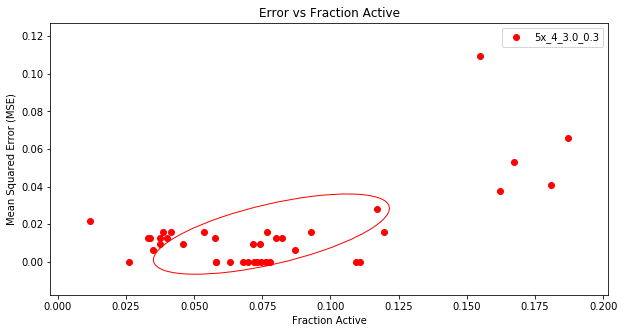

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlabel('Fraction Active')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Error vs Fraction Active')
for v, version in enumerate(versions):
    analyzer = analyzers[version]
    if v == 0:
        print("getting full images")
        full_images = get_full_images(analyzer, num_images)
    print(f"computing {version}")
    img_patches, full_recons, a_vals = get_recon_images(analyzer, full_images)
    img_patches = img_patches[:num_patches]
    full_recons = full_recons[:num_patches]
    a_vals = a_vals[:num_patches]
    normed_patches, normed_recons = get_normed_images(img_patches, full_recons)
    recon_frac_per_img = compute_recon_frac_act(a_vals)
    mse_per_img = mean_squared_error(normed_patches, normed_recons)
    
    ax.scatter(mse_per_img, recon_frac_per_img, marker='o', c=colors[v], label=version)
    confidence_ellipse(mse_per_img, recon_frac_per_img, ax, n_std=1, edgecolor=colors[v])

    ax.legend()
plt.show()

## Generate Activation Plots

ValueError: cannot reshape array of size 819200 into shape (64,20)

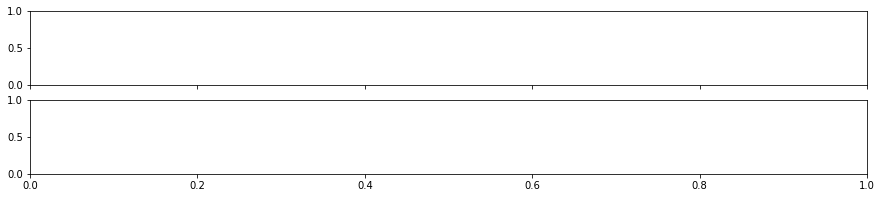

In [194]:
num_rows = 2
fig, ax = plt.subplots(nrows=num_rows, ncols=1, figsize=(15, num_rows*1.5), sharex=True, sharey=True)
for i in range(num_rows):
#     ax[i].bar(np.arange(analyzer.model_params.num_neurons), a_vals[i])
#     ax[i].imshow(a_vals.reshape(64, analyzer.model_params.num_neurons//64))

fig.text(0.5, 0.04, 'Neurons (indices)', ha='center')
# fig.text(0.04, 0.5, 'Activations (Scalar)', va='center', rotation='vertical')
plt.show()

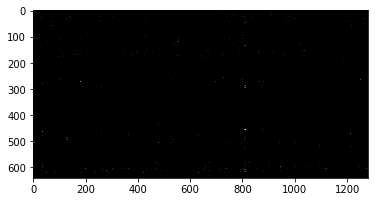

In [203]:
plt.imshow(np.abs(a_vals[:]), cmap="gray")

## reconstruction of the whole image

In [208]:
full_image = full_images
if analyzer.model_params.whiten_data:
  # FT method is the only one that works on full images
  wht_img, img_mean, ft_filter = dp.whiten_data(full_image,
    method="FT", lpf_cutoff=analyzer.model_params.lpf_cutoff)
else:
  wht_img = full_image
img_patches = dp.extract_patches(wht_img,
  out_shape=(1, analyzer.model_params.patch_edge_size, analyzer.model_params.patch_edge_size, 1),
  overlapping=False, randomize=False, var_thresh=0.0)
img_patches, orig_shape = dp.reshape_data(img_patches, flatten=True)[:2]
model_eval = analyzer.evaluate_model(img_patches,
  ["inference/activity:0", "output/reconstruction:0"])
recon_patches = model_eval["output/reconstruction:0"]
a_vals = model_eval["inference/activity:0"]
recon_patches = dp.reshape_data(recon_patches, flatten=False, out_shape=orig_shape)[0]
full_recon = dp.patches_to_image(recon_patches, full_image.shape).astype(np.float32)
if analyzer.model_params.whiten_data:
    full_recon = dp.unwhiten_data(full_recon, img_mean, ft_filter, method="FT")

    

INFO:tensorflow:Restoring parameters from /home/ryanchan/Work/Projects/lca_subspace_vh/checkpoints/lca_subspace_vh_v5x_4_2.0_0.2-100000


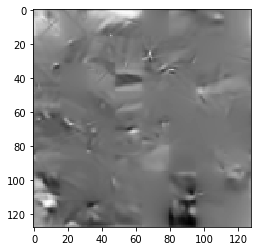

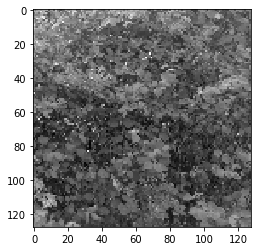

In [219]:
i = 5
plt.imshow(full_recon[i, :, :, 0], cmap="gray"); plt.show()
plt.imshow(full_images[i, :, :, 0], cmap="gray");plt.show()

In [228]:
num_neurons = 256
group_size = 4
num_groups = num_neurons // group_size
R = np.zeros(shape=(num_neurons, num_groups))
for g in range(num_groups):
     R[g:g+group_size, g] = 1

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [231]:
x = np.arange(16).reshape(4, 4)
x[:, 0]

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


array([ 0,  4,  8, 12])